In [1]:
import os
import sys
import networkx as nx
import pandas as pd
import community as community_louvain
import networkx.algorithms.community as nx_comm
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
os.chdir('/home/tduricic/Development/workspace/structure-in-gnn')
from src.data import dataset_handle
os.getcwd()

'/home/tduricic/Development/workspace/structure-in-gnn'

In [2]:
def generate_conf_model(G,seed=0):
    din=[x[1] for x in G.in_degree()]
    dout=[x[1] for x in G.out_degree()]
    GNoisy=nx.directed_configuration_model(din,dout,create_using=nx.DiGraph(),seed=seed)
    keys = [x[0] for x in G.in_degree()]
    G_mapping = dict(zip(range(len(G.nodes())),keys))
    G_rev_mapping = dict(zip(keys,range(len(G.nodes()))))
    GNoisy = nx.relabel_nodes(GNoisy,G_mapping)
    return GNoisy

def generate_modified_conf_model(G, seed=0):
    node_labels_dict = nx.get_node_attributes(G,'label')
    unique_node_labels = set(node_labels.values())
    same_label_subgraphs = {}
    for node_label in unique_node_labels:
        same_label_subgraphs[node_label] = nx.DiGraph()
    edges_to_remove = []
    for edge in G.edges:
        if edge[0] in node_labels_dict and edge[1] in node_labels_dict and node_labels_dict[edge[0]] == node_labels_dict[edge[1]]:
            node_label = G.nodes(data=True)[edge[0]]['label']
            same_label_subgraphs[node_label].add_edge(edge[0], edge[1])
            edges_to_remove.append((edge[0], edge[1]))
    G.remove_edges_from(edges_to_remove)
    for label in same_label_subgraphs:
        G.add_edges_from(generate_conf_model(same_label_subgraphs[label], seed).edges)
    return G

In [4]:
# Download datasets
dataset_handle.create_cora()
dataset_handle.create_citeseer()
dataset_handle.create_texas()
dataset_handle.create_washington()
dataset_handle.create_wisconsin()
# dataset_handle.create_cornell()
dataset_handle.create_webkb()
dataset_handle.create_pubmed()

File downloaded and extracted!
Created data/graphs/processed/cora/cora.cites and data/graphs/processed/cora/cora.content
File downloaded and extracted!
Created data/graphs/processed/citeseer/citeseer.cites and data/graphs/processed/citeseer/citeseer.content
File downloaded and extracted!
Created data/graphs/processed/texas/texas.cites and data/graphs/processed/texas/texas.content
File downloaded and extracted!
Created data/graphs/processed/washington/washington.cites and data/graphs/processed/washington/washington.content
File downloaded and extracted!
Created data/graphs/processed/wisconsin/wisconsin.cites and data/graphs/processed/wisconsin/wisconsin.content
File downloaded and extracted!
Created data/graphs/processed/webkb/webkb.cites and data/graphs/processed/webkb/webkb.content
File downloaded and extracted!


In [30]:
# Create G and label CM G from datasets
datasets = ['cora', 'citeseer', 'webkb', 'pubmed'] #'cornell']
graphs = {}
for dataset in datasets:
    graph_filepath = 'data/graphs/processed/'+ dataset +'/'+ dataset +'.cites'
    original_G = nx.Graph()
    with open(graph_filepath, 'r') as f:
        for line in f:
            edge = line.split()
            original_G.add_edge(edge[0], edge[1])
    node_labels = {}
    features_filepath =  'data/graphs/processed/' + dataset + '/' + dataset + '.content'
    with open(features_filepath, 'r') as f:
        for line in f:
            features = line.split()
            node_id = features[0]
            label = features[-1]
            node_labels[node_id] = label
    for node_id in original_G.nodes:
        if node_id in node_labels:
            original_G.nodes[node_id]['label'] = node_labels[node_id]
    label_cm_G = generate_modified_conf_model(original_G)    
    graphs[dataset] = {'original': original_G, 'label_cm':label_cm_G}

In [32]:
# Run community detection and calculate modularity on original and CM graphs
for run_iteration in range(1,11):
    print(run_iteration)
    for dataset in datasets:
        if run_iteration not in graphs[dataset]:
            graphs[dataset][run_iteration] = {}
        original_G_best_partition = community_louvain.best_partition(graphs[dataset]['original'])
        label_cm_G_best_partition = community_louvain.best_partition(graphs[dataset]['label_cm'])
        graphs[dataset][run_iteration]['num_communities_original'] = len(set(original_G_best_partition.values()))
        graphs[dataset][run_iteration]['num_communities_label_cm'] = len(set(label_cm_G_best_partition.values()))
        original_communities = {}
        for node_id in original_G_best_partition:
            community_id = original_G_best_partition[node_id]
            if community_id not in original_communities:
                original_communities[community_id] = []
            original_communities[community_id].append(node_id)
        label_cm_communities = {}
        for node_id in label_cm_G_best_partition:
            community_id = label_cm_G_best_partition[node_id]
            if community_id not in label_cm_communities:
                label_cm_communities[community_id] = []
            label_cm_communities[community_id].append(node_id)
        graphs[dataset][run_iteration]['modularity_original'] = nx_comm.modularity(graphs[dataset]['original'], list(original_communities.values()))
        graphs[dataset][run_iteration]['modularity_label_cm'] = nx_comm.modularity(graphs[dataset]['label_cm'], list(label_cm_communities.values()))
    run_iteration += 1

1
2
3
4
5
6
7
8
9
10


In [35]:
boxplot_values = []
for dataset in graphs:
    for run_iteration in range(1,11):
        boxplot_values.append({
            'dataset':dataset,
            'Number of communities':graphs[dataset][run_iteration]['num_communities_original'],
            'Modularity':graphs[dataset][run_iteration]['modularity_original'],
            'Graph type':'Original',
            'run_iteration':run_iteration
        })
        boxplot_values.append({
            'dataset':dataset,
            'Number of communities':graphs[dataset][run_iteration]['num_communities_label_cm'],
            'Modularity':graphs[dataset][run_iteration]['modularity_label_cm'],
            'Graph type':'Label CM',
            'run_iteration':run_iteration
        })
df = pd.DataFrame(boxplot_values)

In [36]:
df

,dataset,Number of communities,Modularity,Graph type,run_iteration
0,cora,14,0.709414,Original,1
1,cora,17,0.697475,Label CM,1
2,cora,15,0.712204,Original,2
3,cora,16,0.705260,Label CM,2
4,cora,16,0.700362,Original,3
...,...,...,...,...,...
75,pubmed,183,0.581904,Label CM,8
76,pubmed,206,0.585118,Original,9
77,pubmed,158,0.574047,Label CM,9
78,pubmed,181,0.583477,Original,10


In [24]:
# Calculate d=2 UMAP embeddings for original and CM graphs

In [25]:
# Visualize UMAP embeddings and color by labels

<AxesSubplot:xlabel='dataset', ylabel='Modularity'>

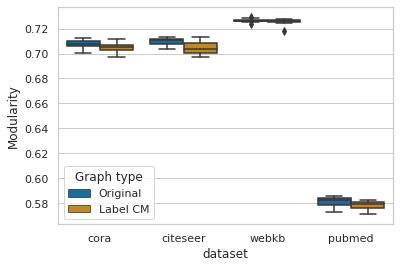

In [38]:
sns.boxplot(y='Modularity', x='dataset', 
                 data=df, 
                 palette="colorblind",
                 hue='Graph type')

<AxesSubplot:xlabel='dataset', ylabel='Number of communities'>

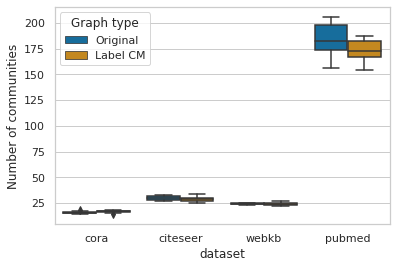

In [39]:
sns.boxplot(y='Number of communities', x='dataset', 
                 data=df, 
                 palette="colorblind",
                 hue='Graph type')